# Data Augmentation

In [ ]:
import json
import os
import random
import numpy as np

#!pip install tqdm
from tqdm import tqdm

#open-cv needed
import cv2 as cv

#!pip install matplotlib
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Quick inspection

In [ ]:
file = open("gdrive/MyDrive/challange/dataset/train/annotations.json", "r")
annotations = json.loads(file.read())
annotations.keys()

dict_keys(['categories', 'info', 'images', 'annotations'])

In [ ]:
print("#categories:", len(annotations['categories']))
print("#info:", len(annotations['info']))
print("#images:", len(annotations['images']))
print("#annotations:", len(annotations['annotations']))

#categories: 273
#info: 2
#images: 24119
#annotations: 39325


In [ ]:
image_files = os.listdir("gdrive/MyDrive/challange/dataset/train/images")
print("#image files:", len(image_files))

OSError: ignored

In [ ]:
crowded_annotations = [a for a in annotations['annotations'] if a['iscrowd'] != 0]
print("#crowded annotation:", len(crowded_annotations))

#crowded annotation: 0


## Examples of data augmentation

In [ ]:
def sp_noise(image, amount=0.01, s_vs_p=0.5):
    row,col,ch = image.shape
    out = np.copy(image)
    
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[tuple(coords)] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    out[tuple(coords)] = 0
    return out

In [ ]:
def rotation_matrix(angle=30):
    return np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

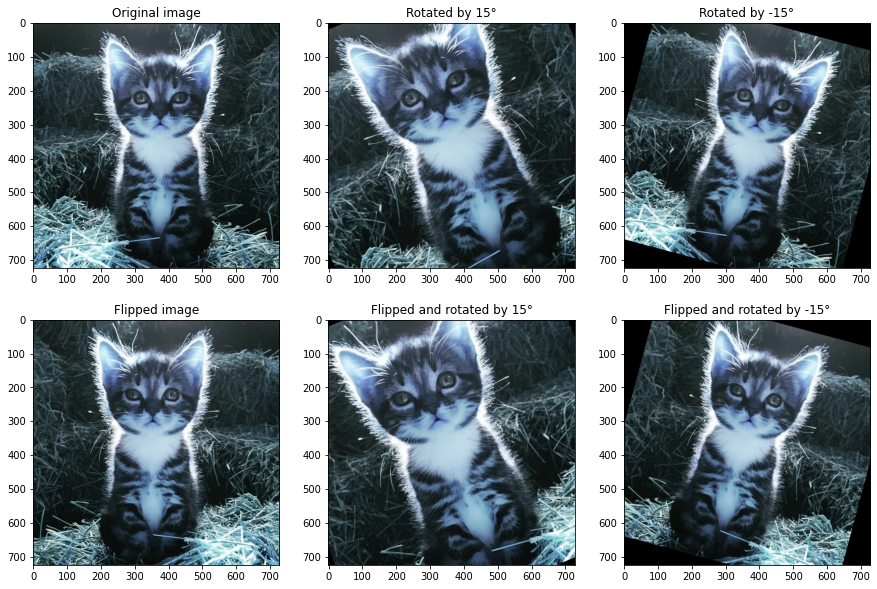

In [ ]:
sample_file = "./images/" + random.sample(image_files, 1)[0]
print(sample_file)

sample_image = cv.imread(sample_file)

sample_image = cv.cvtColor(sample_image, cv.COLOR_BGR2RGB)
flipped_image = cv.flip(sample_image, 1)
image_center = tuple(np.array(sample_image.shape[1::-1]) / 2)
rot_15 = cv.getRotationMatrix2D(image_center, 22.5, 1.25)
rot_minus_15 = cv.getRotationMatrix2D(image_center, -15, 1.0)


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))
ax1.set_title("Original image")
ax2.set_title("Rotated by 15°")
ax3.set_title("Rotated by -15°")
ax4.set_title("Flipped image")
ax5.set_title("Flipped and rotated by 15°")
ax6.set_title("Flipped and rotated by -15°")

ax1.imshow(sample_image);
ax2.imshow(cv.warpAffine(sample_image, rot_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR));
ax3.imshow(cv.warpAffine(sample_image, rot_minus_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR));

ax4.imshow(flipped_image);
ax5.imshow(cv.warpAffine(flipped_image, rot_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR));
ax6.imshow(cv.warpAffine(flipped_image, rot_minus_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR));

## Check transformed segmentation

In [ ]:
def flip_segmentations(image, segs):
    flipped_segs = [[image.shape[0] - seg[0], seg[1]] for seg in segs]
    return np.array(flipped_segs, dtype=np.int32)

./images/096080.jpg
[[[443.0, 958.5, 421.0, 958.5, 395.0, 951.5, 354.0, 933.5, 316.0, 911.5, 282.5, 882.0, 276.5, 869.0, 264.5, 858.0, 259.5, 846.0, 248.5, 834.0, 220.5, 782.0, 214.5, 751.0, 214.5, 728.0, 219.5, 705.0, 233.5, 671.0, 243.5, 657.0, 234.5, 651.0, 234.0, 642.5, 255.0, 636.5, 287.0, 636.5, 300.0, 631.5, 343.0, 629.5, 585.0, 627.5, 618.0, 631.5, 631.5, 645.0, 638.5, 668.0, 632.5, 784.0, 628.5, 797.0, 607.5, 832.0, 597.5000000000001, 857.0, 568.0, 888.5, 537.0, 912.5, 496.0, 935.5]]]


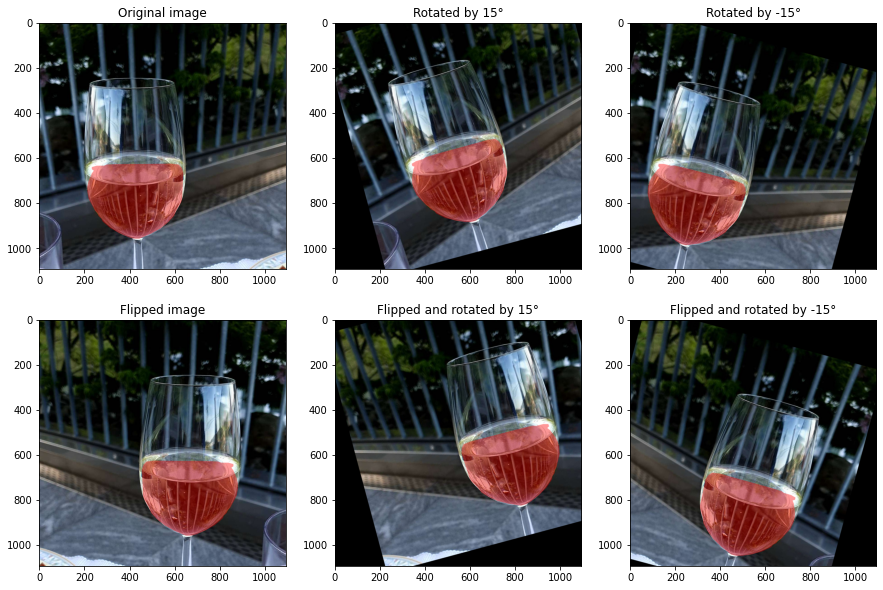

In [ ]:
sample_id = random.sample(image_files, 1)[0][:-4]
sample_file = "./images/" + sample_id + ".jpg"
print(sample_file)

sample_image = cv.imread(sample_file)
sample_image = cv.cvtColor(sample_image, cv.COLOR_BGR2RGB)
image_15 = cv.warpAffine(sample_image, rot_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR)
image_minus_15 = cv.warpAffine(sample_image, rot_minus_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR)
flipped_img = cv.flip(sample_image, 1)
flipped_image_15 = cv.warpAffine(flipped_img, rot_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR)
flipped_image_minus_15 = cv.warpAffine(flipped_img, rot_minus_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR)


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))
ax1.set_title("Original image")
ax2.set_title("Rotated by 15°")
ax3.set_title("Rotated by -15°")
ax4.set_title("Flipped image")
ax5.set_title("Flipped and rotated by 15°")
ax6.set_title("Flipped and rotated by -15°")

sample_segmentations = [a['segmentation'] for a in annotations['annotations']
                        if a['image_id'] == int(sample_id)]
print(sample_segmentations)

seg_image = sample_image.copy()
seg_image_15 = image_15.copy()
seg_image_minus_15 = image_minus_15.copy()
seg_flipped_img = flipped_img.copy()
seg_flipped_image_15 = flipped_image_15.copy()
seg_flipped_image_minus_15 = flipped_image_minus_15.copy()

for idx, seg in enumerate(sample_segmentations):
    for sub_seg in seg:
        sub_seg = np.array(sub_seg, dtype=np.int32)
        sub_seg = sub_seg.reshape(-1, 2)
        ones = np.ones((sub_seg.shape[0], 1))
        sub_seg_15 = np.dot(np.append(sub_seg, ones, axis=1), rot_15.T)
        sub_seg_minus_15 = np.dot(np.append(sub_seg, ones, axis=1), rot_minus_15.T)
        flipped_seg = flip_segmentations(seg_flipped_img, sub_seg)
        flipped_seg_15 = np.dot(np.append(flipped_seg, ones, axis=1), rot_15.T)
        flipped_seg_minus_15 = np.dot(np.append(flipped_seg, ones, axis=1), rot_minus_15.T)
        
        color = 255 - idx*255/len(sample_segmentations)
        seg_image = cv.fillPoly(seg_image, [sub_seg], color, lineType=cv.LINE_AA)
        seg_image_15 = cv.fillPoly(seg_image_15, [np.int32(sub_seg_15)], color, lineType=cv.LINE_AA)
        seg_image_minus_15 = cv.fillPoly(seg_image_minus_15, [np.int32(sub_seg_minus_15)], color, lineType=cv.LINE_AA)
        seg_flipped_img = cv.fillPoly(seg_flipped_img, [flipped_seg], color, lineType=cv.LINE_AA)
        seg_flipped_image_15 = cv.fillPoly(seg_flipped_image_15, [np.int32(flipped_seg_15)], color, lineType=cv.LINE_AA)
        seg_flipped_image_minus_15 = cv.fillPoly(seg_flipped_image_minus_15, [np.int32(flipped_seg_minus_15)], color, lineType=cv.LINE_AA)

ax1.imshow(cv.addWeighted(sample_image, 0.6, seg_image, 0.4, 0));
ax2.imshow(cv.addWeighted(image_15, 0.6, seg_image_15, 0.4, 0));
ax3.imshow(cv.addWeighted(image_minus_15, 0.6, seg_image_minus_15, 0.4, 0));
ax4.imshow(cv.addWeighted(flipped_img, 0.6, seg_flipped_img, 0.4, 0));
ax5.imshow(cv.addWeighted(flipped_image_15, 0.6, seg_flipped_image_15, 0.4, 0));
ax6.imshow(cv.addWeighted(flipped_image_minus_15, 0.6, seg_flipped_image_minus_15, 0.4, 0));


## Perform data augmentation

In [ ]:
for img in tqdm(image_files):
    image_id = int(img[:-4])
    image = cv.imread("./images/" + img)
    image_15 = cv.warpAffine(image, rot_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR)
    image_minus_15 = cv.warpAffine(image, rot_minus_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR)
    flipped_image = cv.flip(image, 1)
    flipped_image_15 = cv.warpAffine(flipped_img, rot_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR)
    flipped_image_minus_15 = cv.warpAffine(flipped_img, rot_minus_15, sample_image.shape[1::-1], flags=cv.INTER_LINEAR)
    
    anns = [ann for ann in annotations['annotations']
                        if ann['image_id'] == img_id]
    
    for ann in anns:
        seg_15 = []
        seg_minus_15 = []
        flipped_seg = []
        flipped_seg_15 = []
        flipped_seg_minus_15 = []
        
        for seg in ann['segmentation']:
            seg = np.array(seg).reshape(-1, 2)
            f_seg = flip_segmentations(image, seg)
            ones = np.ones((seg.shape[0], 1))
            seg_15.append(np.dot(np.append(seg, ones, axis=1), rot_15.T).flatten().tolist())
            seg_minus_15.append(np.dot(np.append(seg, ones, axis=1), rot_minus_15.T).flatten().tolist())
            flipped_seg.append(f_seg.flatten().tolist())
            flipped_seg_15.append(np.dot(np.append(f_seg, ones, axis=1), rot_15.T).flatten().tolist())
            flipped_seg_minus_15.append(np.dot(np.append(f_seg, ones, axis=1), rot_minus_15.T).flatten().tolist())
            
        annotations["annotations"].append({
            "id": int(str(ann["id"]) + "1"),
            "image_id": int(str(image_id) + "1"),
            "category_id": ann["category_id"],
            "segmentation": seg_15,
            "area": ann["area"],
            "bbox": ann["bbox"],
            "iscrowd": ann["iscrowd"],
        })
        annotations["annotations"].append({
            "id": int(str(ann["id"]) + "2"),
            "image_id": int(str(image_id) + "2"),
            "category_id": ann["category_id"],
            "segmentation": seg_minus_15,
            "area": ann["area"],
            "bbox": ann["bbox"],
            "iscrowd": ann["iscrowd"],
        })
        annotations["annotations"].append({
            "id": int(str(ann["id"]) + "3"),
            "image_id": int(str(image_id) + "3"),
            "category_id": ann["category_id"],
            "segmentation": flipped_seg,
            "area": ann["area"],
            "bbox": ann["bbox"],
            "iscrowd": ann["iscrowd"],
        })
        annotations["annotations"].append({
            "id": int(str(ann["id"]) + "4"),
            "image_id": int(str(image_id) + "4"),
            "category_id": ann["category_id"],
            "segmentation": flipped_seg_15,
            "area": ann["area"],
            "bbox": ann["bbox"],
            "iscrowd": ann["iscrowd"],
        })
        annotations["annotations"].append({
            "id": int(str(ann["id"]) + "5"),
            "image_id": int(str(image_id) + "5"),
            "category_id": ann["category_id"],
            "segmentation": flipped_seg_minus_15,
            "area": ann["area"],
            "bbox": ann["bbox"],
            "iscrowd": ann["iscrowd"],
        })
    
    width = image.shape[1]
    height = image.shape[0]
    
    cv.imwrite('./augmentedImages/' + str(image_id) + ".jpg", image[:height, :width])
    cv.imwrite('./augmentedImages/' + str(image_id) + "r15.jpg", image_15[:height, :width]) 
    cv.imwrite('./augmentedImages/' + str(image_id) + "r-15.jpg", image_minus_15[:height, :width])
    cv.imwrite('./augmentedImages/' + str(image_id) + "f.jpg", flipped_image[:height, :width])
    cv.imwrite('./augmentedImages/' + str(image_id) + "fr15.jpg", flipped_image_15[:height, :width]) 
    cv.imwrite('./augmentedImages/' + str(image_id) + "fr-15.jpg", flipped_image_minus_15[:height, :width])
    
    annotations['images'].append({
        "id": int(str(image_id) + "1"), 
        "file_name": str(image_id) + "r15.jpg", 
        "width": width,
        "height": height
    })
    annotations['images'].append({
        "id": int(str(image_id) + "2"), 
        "file_name": str(image_id) + "r-15.jpg", 
        "width": width,
        "height": height
    })
    annotations['images'].append({
        "id": int(str(image_id) + "3"), 
        "file_name": str(image_id) + "f.jpg", 
        "width": width,
        "height": height
    })
    annotations['images'].append({
        "id": int(str(image_id) + "4"), 
        "file_name": str(image_id) + "fr15.jpg", 
        "width": width,
        "height": height
    })
    annotations['images'].append({
        "id": int(str(image_id) + "5"), 
        "file_name": str(image_id) + "f.jpg", 
        "width": width,
        "height": height
    })
    
    

with open('augmentedAnnotations.json', 'w') as f:
    json.dump(annotations, f)

100%|██████████| 24120/24120 [26:08<00:00, 15.38it/s] 
